In [1]:
# import necessary libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
import re

In [2]:
train = pd.read_csv('/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv', encoding = 'latin-1')
test = pd.read_csv('/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv', encoding='latin-1')

len(train), len(test)

(41157, 3798)

I used the `latin-1` encoding since the default encoding, `utf-8`, led to an encoding error. Let's take a look at some of the entries in the train dataset.

In [3]:
train.sample(10)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
26759,30558,75510,"South East, England",02-04-2020,It has been reported that #foodmanufacturers h...,Negative
18662,22461,67413,"Gurgaon, India",23-03-2020,Report: Use alcohol based sanitizer to kill #c...,Extremely Negative
20404,24203,69155,UK,25-03-2020,Italians have realised there s no need to pani...,Negative
17384,21183,66135,"Saskatoon, Saskatchewan",23-03-2020,#COVID19 #coronavirus\r\r\n\r\r\nWhile I agree...,Positive
26157,29956,74908,new york,02-04-2020,New York s Food Pantries Face An Unprecedente...,Neutral
18684,22483,67435,Singapore,23-03-2020,Attention everyone! We use hand sanitizer that...,Extremely Positive
5278,9077,54029,NaN,18-03-2020,Some lady thatÂs not even my customer from ac...,Neutral
13248,17047,61999,"Nottingham, UK",21-03-2020,I should have bought this when I had a chance ...,Positive
36128,39927,84879,NaN,09-04-2020,Better to have and not need than need it and n...,Extremely Positive
9576,13375,58327,Swaziland,20-03-2020,Can the faculty of Science and Engineering in ...,Positive


## Cleaning

Let's make some utility functions to clean up the dataset especially the `OriginalTweet` column since it's an important feature to predict our target `Sentiment`.

In [4]:
from nltk.corpus import stopwords

stopwords = set(stopwords.words('english'))

In [5]:
def cleanup(text):
    # remove links
    links = re.compile(r'https?://\S+|www\.\S+')
    text = links.sub('', text)
    
    # remove html
    html = re.compile(r"<.*?>")
    text = html.sub('', text)
    
    # remove num
    text = re.sub(r'\d+', '', text)
    
    # remove mentions - (@s)
    text=re.sub(r'@\w+','',text)
    
    # remove numbers 
    text = re.sub(r'\d+', '', text)
    
    # remove punct
    text = re.sub(r"[^\w\s\d]","", text)
    
    # remove space
    text = re.sub(r"\s+"," ",text).strip()
    return text

Using a new column `Tweet` so the original column `OriginalTweet` doesn't get overwritten

In [6]:
train['Tweet'] = train['OriginalTweet'].apply(lambda x: cleanup(x))

## Exploratory Data Analysis

In [7]:
train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,and and
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advice Talk to your neighbours family to excha...
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,Coronavirus Australia Woolworths to give elder...
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,My food stock is not the only one which is emp...
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,Me ready to go at supermarket during the COVID...


Let's see if there's any missing entry in the train dataset

In [8]:
train.isnull().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
Tweet               0
dtype: int64

We can see that the `Location` feature is missing for 8590 observations in the dataset. Let's see the top 10 most frequent locations where the tweets in the dataset come from.

In [9]:
train['Location'].value_counts()[:10]

London             540
United States      528
London, England    520
New York, NY       395
Washington, DC     373
United Kingdom     337
Los Angeles, CA    281
India              268
UK                 232
Australia          225
Name: Location, dtype: int64

<BarContainer object of 10 artists>

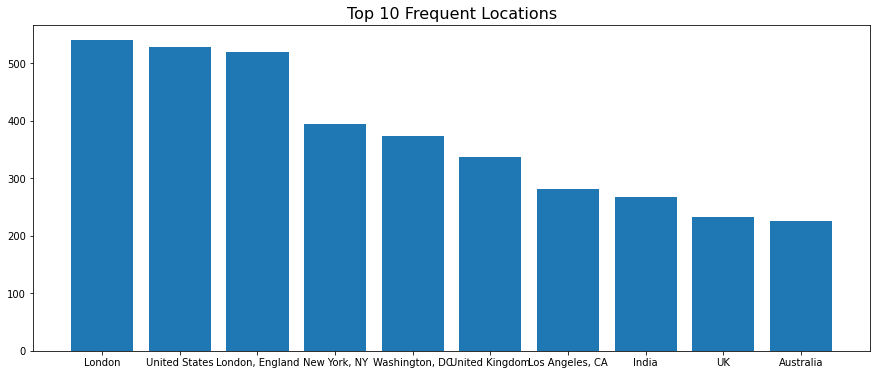

In [10]:
top_location = train['Location'].value_counts()[:10]

# make a plot
plt.figure(figsize=(15,6))
plt.title("Top 10 Frequent Locations", fontsize = 16)
plt.bar(top_location.index, height = top_location.values)

We can see from above that the top location for the tweets in the dataset is London. A second top location is `United States`. On a closer look, we also see that we have `London, England` present in the dataset which refer to the same location. 

Let's shift attention away from the Location feature and see the distribution of the `Sentiment` feature by number of observations in the train dataset.

In [11]:
train['Sentiment'].value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

As we see from above, the sentiment from the train dataset is divided into 5 categories - `Positive`, `Negative`, `Neutral`, `Extremely Positive`, and `Extremely Negative`. And that the `Positive` tweets have the highest distribution. 

Let's visualize this information in a barchart using Seaborn's tool.

Text(0, 0.5, 'Count')

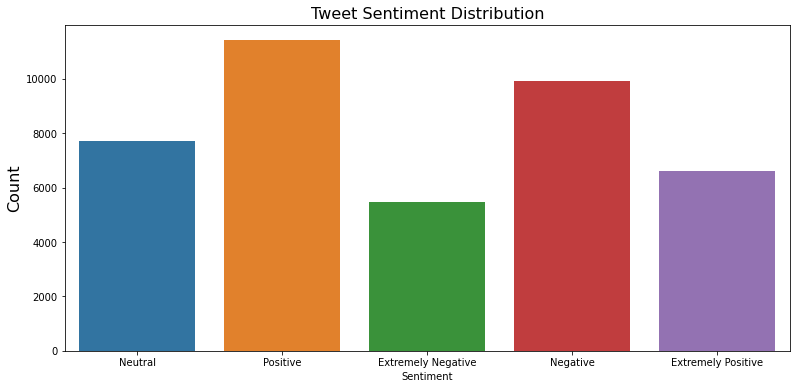

In [12]:
plt.figure(figsize=(13,6))
sns.countplot(x = train['Sentiment'])
plt.title('Tweet Sentiment Distribution', fontsize = 16)
plt.ylabel("Count", fontsize = 16)

### Positive Tweets

Let's see some of these positive tweets

In [13]:
pos_tweets = train[train['Sentiment'] == 'Positive'].loc[:, 'Tweet'].values.tolist()

# let's see 5 of these tweets
for tweet in pos_tweets[:5]:
    print(tweet)
    print("\n")

advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order


Coronavirus Australia Woolworths to give elderly disabled dedicated shopping hours amid COVID outbreak


My food stock is not the only one which is empty PLEASE dont panic THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need Stay calm stay safe COVIDfrance COVID_ COVID coronavirus confinement Confinementotal ConfinementGeneral


As news of the regionÂs first confirmed COVID case came out of Sullivan County last week people flocked to area stores to purchase cleaning supplies hand sanitizer food toilet paper and other goods reports


Cashier at grocery store was sharing his insights on Covid_ To prove his credibility he commented Im in Civics class so I know what Im talking about




Text(0.5, 1.0, 'Word Frequency Distribution in the Positive Tweets')

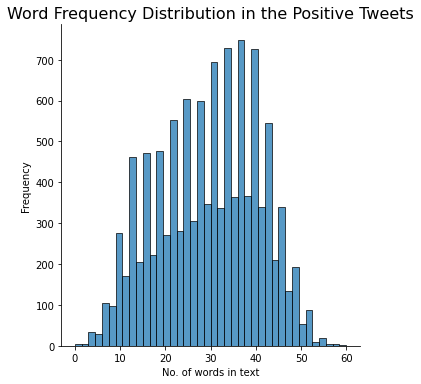

In [14]:
# let's get the distribution of word counts in the Positive Tweets

text_size = list(map(lambda x: len(x.split()), pos_tweets))
sns.displot(text_size)
plt.xlabel('No. of words in text')
plt.ylabel('Frequency')
plt.title('Word Frequency Distribution in the Positive Tweets', fontsize = 16)

In [15]:
mean = pd.Series(text_size).mean()

print(f"The average number of words per entry for Positive Tweets is {int(mean)}")

The average number of words per entry for Positive Tweets is 29


Let's see some of the most common words in the Positive tweets using the WordCloud library.

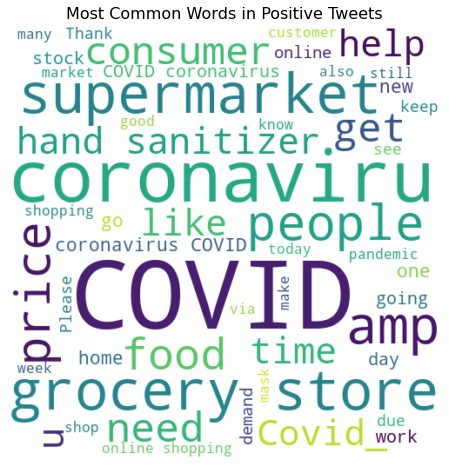

In [16]:
from wordcloud import WordCloud

corpus = ' '.join(text for text in pos_tweets)

wordcloud = WordCloud(width=500, height = 500 ,max_words = 50, 
                      background_color = 'white', stopwords = stopwords)
wordcloud.generate(corpus)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Most Common Words in Positive Tweets", fontsize = 16)
plt.axis('off')

plt.show()

Let's do similar for `Negative` and `Neutral` tweets

### Negative Tweets

In [17]:
neg_tweets = train[train['Sentiment'] == 'Negative'].loc[:, 'Tweet'].values.tolist()

# let's see 5 of these tweets
for tweet in neg_tweets[:5]:
    print(tweet)
    print("\n")

For corona preventionwe should stop to buy things with the cash and should use online payment methods because corona can spread through the notes Also we should prefer online shopping from our home Its time to fight against COVID govindia IndiaFightsCorona


what is being done to ensure food and other essential products are being restocked at supermarkets and panic buying actively discouraged It cannot be left to checkout staff to police the actions of the selfish and profiteer


In preparation for higher demand and a potential food shortage The Hunger Coalition purchased percent more food and implemented new protocols due to the COVID coronavirus


Do you see malicious price increases in NYC The NYC Department of Consumer and Worker Protection DCWP has set up a page to digitally file a complaint Click here To file a complaint use the wordOvercharge COVID CovidNYC


There Is of in the Country The more empty shelves people see the more buying ensues the more food is out of stock




Text(0.5, 1.0, 'Word Frequency Distribution in the Negative Tweets')

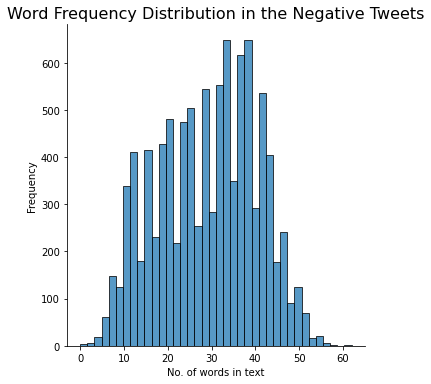

In [18]:
# let's get the distribution of word counts in the Negative Tweets

text_size = list(map(lambda x: len(x.split()), neg_tweets))
sns.displot(text_size)
plt.xlabel('No. of words in text')
plt.ylabel('Frequency')
plt.title('Word Frequency Distribution in the Negative Tweets', fontsize = 16)

In [19]:
mean = pd.Series(text_size).mean()

print(f"The average number of words per entry for Negative Tweets is {int(mean)}")

The average number of words per entry for Negative Tweets is 29


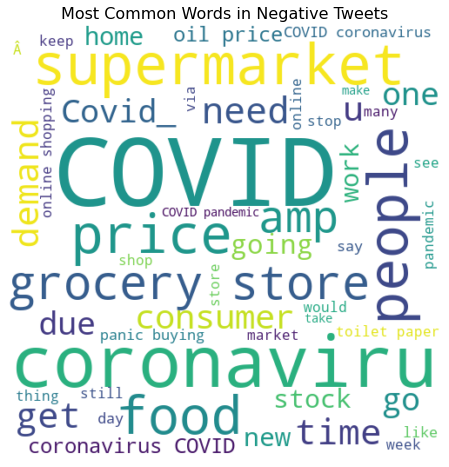

In [20]:
corpus = ' '.join(text for text in neg_tweets)
wordcloud = WordCloud(width=500, height = 500 ,max_words = 50, 
                      background_color = 'white', stopwords = stopwords)
wordcloud.generate(corpus)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Most Common Words in Negative Tweets", fontsize = 16)
plt.axis('off')

plt.show()

### Neutral Tweets

In [21]:
neut_tweets = train[train['Sentiment'] == 'Neutral'].loc[:, 'Tweet'].values.tolist()

# let's see 5 of these tweets
for tweet in neut_tweets[:5]:
    print(tweet)
    print("\n")

and and


Was at the supermarket today Didnt buy toilet paper Rebel toiletpapercrisis covid_


All month there hasnt been crowding in the supermarkets or restaurants however reducing all the hours and closing the malls means everyone is now using the same entrance and dependent on a single supermarket manila lockdown covid Philippines


_ _


MAR Russia consumer surveillance watchdog reported case in high Arctic where a man who traveled to Iran has COVID and are observed




Text(0.5, 1.0, 'Word Frequency Distribution in the Neutral Tweets')

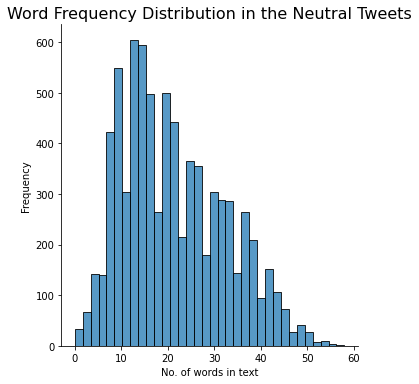

In [22]:
# let's get the distribution of word counts in the Neutral Tweets

text_size = list(map(lambda x: len(x.split()), neut_tweets))
sns.displot(text_size)
plt.xlabel('No. of words in text')
plt.ylabel('Frequency')
plt.title('Word Frequency Distribution in the Neutral Tweets', fontsize = 16)

In [23]:
mean = pd.Series(text_size).mean()

print(f"The average number of words per entry for Neutral Tweets is {int(mean)}")

The average number of words per entry for Neutral Tweets is 21


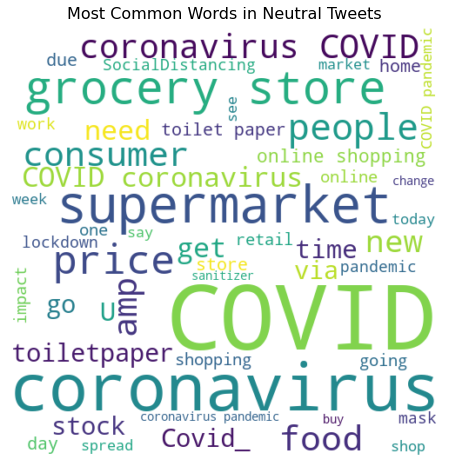

In [24]:
corpus = ' '.join(text for text in neut_tweets)
wordcloud = WordCloud(width=500, height = 500 ,max_words = 50, 
                      background_color = 'white', stopwords = stopwords)
wordcloud.generate(corpus)

plt.figure(figsize=(10, 8))
plt.title("Most Common Words in Neutral Tweets", fontsize = 16)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.show()

In general, we learnt the following from the dataset:

* The location with the highest number of tweets is London in the United Kingdom. Other top locations are: United States, India and Australia.
* The word length per tweet in the different sentiments range from 21 - 30.



* The tweets with the Positive Sentiment have the highest number of observations and followed by that of the Negative Sentiment. 
* The most common words used in the tweets of positive sentiments asides the terms Covid and Coronavirus are grocery, shopping, sanitizer, mask and food.
* The most common words used in the tweets of negative sentiments asides the terms Covid and Coronavirus are panic, buying, supermarket, price and work.
* The most common words used in the tweets of neutral sentiments asides the terms Covid and Coronavirus are SocialDistancing, toiletpaper, pandemic and food.

Although the following observations made from the WordClouds of the different sentiments do not seem to be very different or particularly helpful, we could make the assumptions that tweeters use the same words in different contexts for the different sentiments. 

## Preparation for modelling

In [25]:
train.sample(3)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
7279,11078,56030,England,19-03-2020,ItÂs a disgrace how some Asian supermarkets a...,Negative,ItÂs a disgrace how some Asian supermarkets ar...
2135,5934,50886,Oregon,17-03-2020,Real heroes in the COVID-19 crisis:\r\r\n\r\r\...,Negative,Real heroes in the COVID crisis Frontline doct...
26965,30764,75716,NaN,02-04-2020,Y en tierras aztecas todo sube\r\r\n\r\r\nWorl...,Neutral,Y en tierras aztecas todo sube World food pric...


In [26]:
train_texts = train['Tweet'].values.tolist()

Let's encode the `Sentiment` class

In [27]:
sentiment_map = {"Neutral": 0, "Positive": 1, "Negative": 2, "Extremely Positive": 3, "Extremely Negative": 4}
train['Sentiment_mapped'] = train['Sentiment'].map(sentiment_map)

In [28]:
train_labels = train['Sentiment_mapped'].values.tolist()
train_labels = np.array(train_labels)

In [29]:
# for the test

test['Tweet'] = test['OriginalTweet'].apply(lambda x: cleanup(x))
test_texts = test['Tweet'].values.tolist()

test['Sentiment_mapped'] = test['Sentiment'].map(sentiment_map)
test_labels = test['Sentiment_mapped'].values.tolist()
test_labels = np.array(test_labels)

## ML Models

### Logistic Regression

I used Scikit-Learn's CountVectorizer tool to tokenize and vectorize the texts in the train dataset

In [30]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()
cv.fit(train_texts)

train_sequences = cv.transform(train_texts)
test_sequences = cv.transform(test_texts)

In [31]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(train_sequences, train_labels)
y_pred = model.predict(test_sequences)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [32]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(test_labels, y_pred)


print(f"Accuraccy: {round(acc, 2)}")

Accuraccy: 0.61


In [33]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize='true')
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
    disp.plot(cmap='Blues', values_format = '.2f', ax = ax, colorbar = False)
    plt.title('Normalized confusion matrix', fontsize = 16)
    
    plt.show()

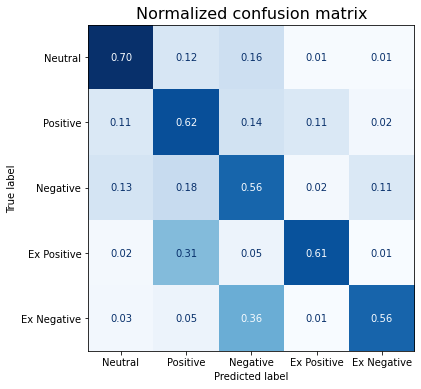

In [34]:
categories = ["Neutral", "Positive", "Negative", "Ex Positive", "Ex Negative"]

plot_confusion_matrix(y_pred,test_labels, categories)

### LSTM

#### Tokenization

Let's use TensorFlow's tokenizer tool as we move on

In [35]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

num_words = 30000
maxlen = 25 # based on the average tweet length

tokenizer = Tokenizer(num_words = num_words)
tokenizer.fit_on_texts(train_texts)

train_sequences = tokenizer.texts_to_sequences(train_texts)
train_sequences = pad_sequences(train_sequences, maxlen = maxlen)

test_sequences = tokenizer.texts_to_sequences(test_texts)
test_sequences = pad_sequences(test_sequences, maxlen = maxlen)

In [36]:
# sanity check
print(train_sequences[5], train_labels[5])
print(tokenizer.sequences_to_texts([train_sequences[5]]))
print(train.loc[5, 'Tweet'])

[  765    41     5 15420   862   190   160    29 10794     2   596   112
     2   670   660   188    81    68    18   101   107     3    99   291
   454] 1
['came out of sullivan county last week people flocked to area stores to purchase cleaning supplies hand sanitizer food toilet paper and other goods reports']
As news of the regionÂs first confirmed COVID case came out of Sullivan County last week people flocked to area stores to purchase cleaning supplies hand sanitizer food toilet paper and other goods reports


In [37]:
model = models.Sequential(name = 'baseline_model')
model.add(layers.Embedding(input_dim = num_words, output_dim = 100, input_length = maxlen))
model.add(layers.LSTM(64, dropout=0.2, return_sequences = False))
model.add(layers.Dense(5, activation = 'softmax'))

2023-01-13 11:55:35.639625: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-13 11:55:35.740822: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-13 11:55:35.741715: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-13 11:55:35.743760: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [38]:
model.compile(optimizer='adam', metrics = ['acc'], loss = 'sparse_categorical_crossentropy')

In [39]:
history = model.fit(train_sequences, train_labels, epochs = 3, validation_split = 0.1)

2023-01-13 11:55:38.652117: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/3


2023-01-13 11:55:41.108741: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1158/1158 [==============================] - 10s 5ms/step - loss: 1.1654 - acc: 0.5115 - val_loss: 0.9011 - val_acc: 0.6494
Epoch 2/3
1158/1158 [==============================] - 5s 5ms/step - loss: 0.7782 - acc: 0.7098 - val_loss: 0.8763 - val_acc: 0.6662
Epoch 3/3
1158/1158 [==============================] - 6s 5ms/step - loss: 0.5851 - acc: 0.7903 - val_loss: 0.9580 - val_acc: 0.6438


In [40]:
y_pred = model.predict(test_sequences)
y_pred = np.argmax(y_pred, axis = 1)
y_pred

array([2, 1, 3, ..., 0, 4, 3])

In [41]:
acc = accuracy_score(test_labels, y_pred)
print(f"Accuracy: {round(acc, 2)}")

Accuracy: 0.61


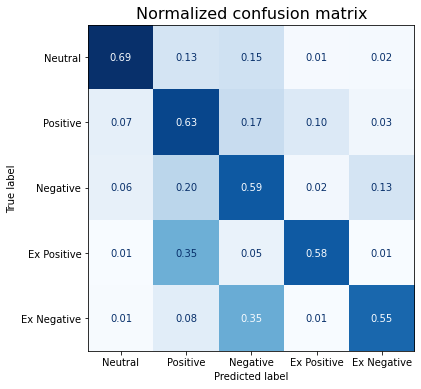

In [42]:
plot_confusion_matrix(y_pred,test_labels, categories)

From the results above, we see that we achieved similar classification accuracies on the Logistic Regression model and LSTM model on the test dataset - 61% accuracy. We also observe similar trends in the Confusion matrices for both models.

From the Confusion matrix above, we see that the `Extremely Positive` class and the `Positive` Class misclassify with each other a lot and the `Extremely Negative` class and the `Negative` class also misclassify with each other a lot. This could lead to a lower classification accuracy.

Let's see if we simplify the labels, we could increase the results.

## Improvement

We could simplify the labels to `Neutral`,`Positive` and `Negative` labels only and see if they improve the results. 

Let's see the train dataset again

In [43]:
train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet,Sentiment_mapped
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,and and,0
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advice Talk to your neighbours family to excha...,1
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,Coronavirus Australia Woolworths to give elder...,1
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,My food stock is not the only one which is emp...,1
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,Me ready to go at supermarket during the COVID...,4


And like before:

In [44]:
sentiment_map = {"Neutral": 0, "Positive": 1, "Negative": 2, "Extremely Positive": 1, "Extremely Negative": 2}
train['Sentiment_mapped'] = train['Sentiment'].map(sentiment_map)
test['Sentiment_mapped'] = test['Sentiment'].map(sentiment_map)

In [45]:
train['Sentiment_mapped'].value_counts()

1    18046
2    15398
0     7713
Name: Sentiment_mapped, dtype: int64

We see that the `Positive` class or Class 1 has the highest observations while the `Neutral` class or Class 0 has the least observation.

In [46]:
train_labels = train['Sentiment_mapped'].values.tolist()
train_labels = np.array(train_labels)

test_labels = test['Sentiment_mapped'].values.tolist()
test_labels = np.array(test_labels)

Using the same LSTM model as above

In [47]:
model = models.Sequential(name = 'baseline_model')
model.add(layers.Embedding(input_dim = num_words, output_dim = 100, input_length = maxlen))
model.add(layers.LSTM(64, dropout=0.2, return_sequences = False))
model.add(layers.Dense(3, activation = 'softmax'))

In [48]:
model.compile(optimizer='adam', metrics = ['acc'], loss = 'sparse_categorical_crossentropy')
history = model.fit(train_sequences, train_labels, epochs = 3, validation_split = 0.1)

Epoch 1/3
1158/1158 [==============================] - 7s 5ms/step - loss: 0.7050 - acc: 0.6968 - val_loss: 0.5627 - val_acc: 0.7872
Epoch 2/3
1158/1158 [==============================] - 6s 5ms/step - loss: 0.4340 - acc: 0.8402 - val_loss: 0.5411 - val_acc: 0.8005
Epoch 3/3
1158/1158 [==============================] - 5s 5ms/step - loss: 0.3124 - acc: 0.8876 - val_loss: 0.6548 - val_acc: 0.7792


In [49]:
y_pred = model.predict(test_sequences)
y_pred = np.argmax(y_pred, axis = 1)
y_pred

array([2, 1, 1, ..., 0, 2, 1])

In [50]:
acc = accuracy_score(test_labels, y_pred)
print(acc)

0.7714586624539231


We achieved 75.8% accuracy on the test dataset after training on the LSTM model on a reduced number of labels.

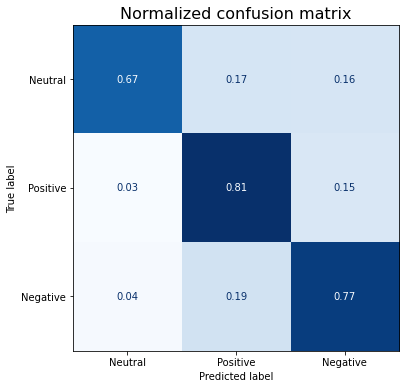

In [51]:
categories = ['Neutral', 'Positive', 'Negative']
plot_confusion_matrix(y_pred,test_labels, categories)

We see that we have higher classification accuracy on the test model from the approach where we simplied the Sentiments to Neutral, Negative and Positive. 

From the Confusion Matrix above, we see that the 
* Neutral class misclassify the Positive class (0.19) more than the Negative class. 
* The Positive Class is most accurately classified. This probably has to deal with the fact that it has higher observations in the dataset. 
* Finally, the Negative class misclassify the Positive class (0.23) than the Neutral class (0.05).